In [74]:
from cvxopt import matrix, solvers
import numpy as np
import os
import matplotlib.pyplot as plt

SEED = 462
np.random.seed(SEED)

data_path = os.path.join("data", "tabular")

## Soft-Margin SVM

$$
min_\alpha \frac{1}{2}\sum_{m=1}^N\sum_{n=1}^N\alpha_n\alpha_my_ny_mx_n^Tx_m - \sum_{n=1}^N\alpha_n
$$

$$
s.t.\ \sum_{n=1}^Ny_n\alpha_n = 0
$$

$$
\ \ \ \ \ \ 0 \leq \alpha_n \leq C
$$

$$
n=1,\dots,N
$$

## QP Solver Representation

```python3
solvers.qp(Q, p, G, h, A, b)
```

Where the problem is:
$$
min_x \frac{1}{2}x^TQx + p^Tx
$$

$$
s.t.\ Gx \leq h
$$

$$
\ \ \ \ \ \ Ax = b
$$

## What to do

We need to convert Soft-Margin SVM representation into QP solver one.

In [75]:
class Dataset:
    """
    This class is taken directly from our previous submission.
    """
    def __init__(self, train_path=None, val_path=None, test_path=None):
        self.train_path = train_path
        self.val_path = val_path
        self.test_path = test_path
    
    def load_csv(self, path):
        data = pd.read_csv(path).to_numpy()
        X, Y_str = data[:, :-1], data[:, -1]  # separate data and target
        n_examples = len(Y_str)
        Y = np.zeros(n_examples)
        for i in range(n_examples):
            category = Y_str[i]
            if category == "banana":
                Y[i] = 0
            elif category == "carrot":
                Y[i] = 1
            elif category == "cucumber":
                Y[i] = 2
            elif category == "mandarin":
                Y[i] = 3
            else:
                Y[i] = 4
        
        return X.astype(float), Y.astype(float)
    
    def get_data(self):
        X_train, Y_train = self.load_csv(self.train_path)
        X_val, Y_val     = self.load_csv(self.val_path)
        X_test, Y_test   = self.load_csv(self.test_path)
        
        return (X_train, Y_train), (X_val, Y_val), (X_test, Y_test)

In [76]:
class SoftMarginSVM:
    def __init__(self, C):
        self.weights = None
        self.bias    = None
        self.C       = C  # soft margin svm gets closer to hard when C gets greater
        
    def train(self, X, Y):
        n_examples, n_features = X.shape

        # we need to calculate Q using y_n*y_m and x_n^Tx_m
        Y = Y.reshape(-1, 1)    # to prevent np to give a scalar make it Nx1
        Y_mul = np.dot(Y, Y.T)  # NxN
        X_mul = np.dot(X, X.T)  # NxN

        Q = Y_mul * X_mul
        p = (np.ones(n_examples) * -1).reshape(-1, 1)

        # G is supposed to be (2N)xN
        G_first_half  = np.eye(n_examples) * -1  # greater than or equal to 0
        G_second_half = np.eye(n_examples)       # less than or equal to C
        G = np.vstack([G_first_half, G_second_half])
        h_first_half  = np.zeros(n_examples).reshape(-1, 1)
        h_second_half = (np.ones(n_examples) * self.C).reshape(-1, 1)
        h = np.vstack([h_first_half, h_second_half])

        A = Y.reshape(1, -1)
        b = 0.0  # cvxopt expects double-precision

        sol=solvers.qp(matrix(Q), matrix(p), matrix(G), matrix(h), matrix(A), matrix(b))

        # next: use sol["x"] to extract optimal alphas and then calculate w and b
        # calculate w*
        alpha_star     = np.array(sol["x"]).reshape(-1, 1)  # Nx1
        weighted_label = Y * alpha_star  # results in Nx1
        w_star         = np.dot(X.T, weighted_label)  # results in dx1 where d is the n_featuresy
        self.weights   = w_star

        # calculate b*
        epsilon = 1e-6  # since optimizers do not work with total precision
        sv_mask = ((alpha_star > epsilon) & (alpha_star < (self.C - epsilon))).flatten()  # flatten is used to prevent IndexError
        # numpy needs this to apply the mask row-wise
        Y_s     = Y[sv_mask]
        X_s     = X[sv_mask]
        pred    = np.dot(X_s, w_star)
        bias    = Y_s - pred
        self.bias = np.mean(bias)

    def predict(self, X):
        return np.sign(np.dot(X, self.weights) + self.bias)

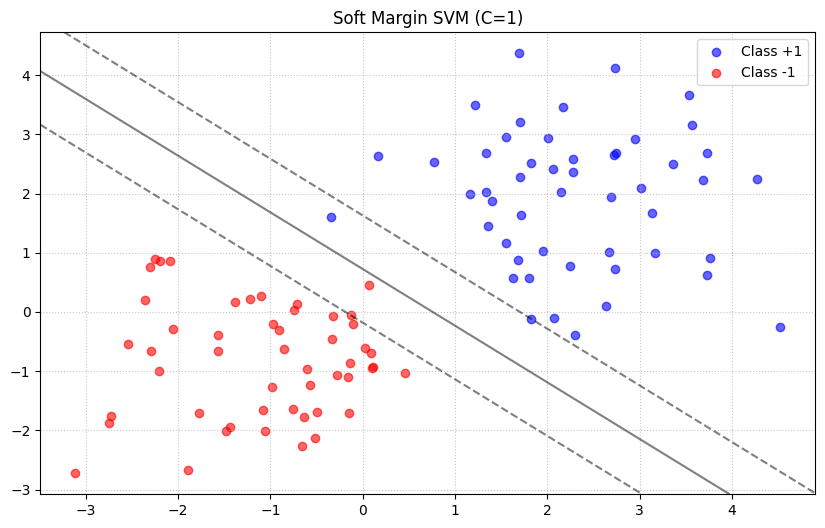

Weights:
[[1.05779869]
 [1.10487775]]
Bias: -0.7994486099285557


In [ ]:
# below is generated by an LLM to test the svm
from cvxopt import matrix, solvers

# Suppress CVXOPT output for a cleaner notebook
solvers.options['show_progress'] = False

# 1. Generate Synthetic Data
np.random.seed(462)
def generate_data(n_samples=50):
    # Cluster 1
    X1 = np.random.randn(n_samples, 2) + np.array([2, 2])
    y1 = np.ones(n_samples)
    # Cluster 2
    X2 = np.random.randn(n_samples, 2) + np.array([-1, -1])
    y2 = -np.ones(n_samples)
    
    X = np.vstack([X1, X2])
    y = np.hstack([y1, y2])
    return X, y

X_train, y_train = generate_data()

# 2. Initialize and Train Your Model
C_value = 1  # Try changing this to 0.01 or 100 to see the effect # NOTE: 0.1 GIVES NAN BIAS
svm = SoftMarginSVM(C=C_value)
svm.train(X_train, y_train)

# 3. Visualization Function
def plot_svm(X, y, model):
    plt.figure(figsize=(10, 6))
    
    # Plot data points
    plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', label='Class +1', alpha=0.6)
    plt.scatter(X[y==-1, 0], X[y==-1, 1], color='red', label='Class -1', alpha=0.6)
    
    # Create grid to plot boundary
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    
    # Predict over the grid
    Z = np.dot(np.c_[xx.ravel(), yy.ravel()], model.weights) + model.bias
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary (Z=0) and margins (Z=1, Z=-1)
    ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    plt.title(f"Soft Margin SVM (C={model.C})")
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()

# Run the visualization
plot_svm(X_train, y_train, svm)

# 4. Print results
print(f"Weights:\n{svm.weights}")
print(f"Bias: {svm.bias}")